In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

# making all pandas columns visable with display command
pd.set_option('display.max_columns', 500)

In [4]:
train=pd.read_csv("datasets/epl_data_train_onehot.csv")
test=pd.read_csv("datasets/epl_data_test_onehot.csv")

In [5]:
X_train = train.drop(columns = ['FTR','final1','final2'])
y_train = train['FTR']
print(X_train.shape)
print(y_train.shape)

(2660, 29)
(2660,)


In [6]:
featuresList = list(X_train.columns) 
targetList = ["0","1","2"]

In [7]:
X_test = test.drop(columns = ['FTR','final1','final2'])
y_test = test['FTR']
print(X_test.shape)
print(y_test.shape)

(380, 29)
(380,)


In [8]:
columns = X_train.shape[1]
columns

29

In [8]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254, 258, 262, 266, 270, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 313, 317, 321, 325, 329, 333, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [12]:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [13]:
rf_random.best_params_

{'n_estimators': 305,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [9]:
#best param
rf = RandomForestClassifier(n_estimators= 305,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'auto',
 max_depth= 4,
 bootstrap= True)
rf.fit(X_train, y_train)
y_pred= rf.predict(X_test)

In [10]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5394736842105263


In [11]:
estimator = rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = featuresList,
                class_names = targetList,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [12]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [28]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(featuresList, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: DiffLP               Importance: 0.21
Variable: HTGD                 Importance: 0.13
Variable: DiffPts              Importance: 0.13
Variable: ATGD                 Importance: 0.09
Variable: ATP                  Importance: 0.07
Variable: DiffFormPts          Importance: 0.07
Variable: HTP                  Importance: 0.06
Variable: HTGS                 Importance: 0.05
Variable: ATGS                 Importance: 0.04
Variable: ATGC                 Importance: 0.03
Variable: HTGC                 Importance: 0.02
Variable: HM1                  Importance: 0.02
Variable: AM1                  Importance: 0.02
Variable: HM2                  Importance: 0.01
Variable: HM3                  Importance: 0.01
Variable: HM4                  Importance: 0.01
Variable: AM3                  Importance: 0.01
Variable: HM5                  Importance: 0.0
Variable: AM2                  Importance: 0.0
Variable: AM4                  Importance: 0.0
Variable: AM5                  Importance: 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

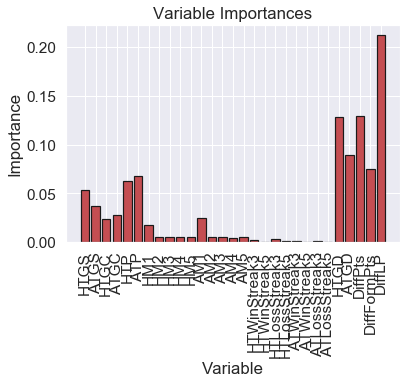

In [26]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, featuresList, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
